# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path

from tqdm import tqdm

# Define Classes/Functions

In [2]:
HIDDEN = 8  # CA state-space dimensionality
DIM = 4  # Embedder output dimensionality
RES = 64  # Resolution of CA grid


# def augment(x):
#     xx = x + 0.4*torch.randn_like(x) + 0.2*torch.randn(x.size(0)).cuda().view(x.size(0),1,1,1)
#     xx = xx*(2*torch.randint(2,(x.size(0),)).float().cuda().view(x.size(0),1,1,1)-1)
#     xx = xx[:,:,8:-8,8:-8]
    
#     return xx


def totalistic(x):
    z = 0.125 * (x + x.flip(2) + x.flip(3) + x.flip(2).flip(3))
    z = z + 0.125 * (x.transpose(2, 3) + x.transpose(2, 3).flip(2) + x.transpose(2, 3).flip(3) + x.transpose(2, 3).flip(
        2).flip(3))
    z = z - z.mean(3).mean(2).unsqueeze(2).unsqueeze(3)

    return z


class Rule(nn.Module):
    def __init__(self):
        super().__init__()
        self.filter1 = nn.Parameter(torch.randn(HIDDEN, 1, 5, 5)/sqrt(HIDDEN))
        self.bias1 = nn.Parameter(0*torch.randn(HIDDEN))

        self.filter2 = nn.Conv2d(HIDDEN, HIDDEN, 1, padding=0)
        nn.init.orthogonal_(self.filter2.weight, gain=2)
        nn.init.zeros_(self.filter2.bias)
        self.filter3 = nn.Conv2d(HIDDEN, HIDDEN, 1, padding=0)
        nn.init.orthogonal_(self.filter3.weight, gain=2)
        nn.init.zeros_(self.filter3.bias)


class CA(nn.Module):
    def __init__(self):
        super().__init__()

        self.rule = Rule()
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-3)

    def initGrid(self, BS):
        self.psi = torch.cuda.FloatTensor(2 * np.random.rand(BS, HIDDEN, RES, RES) - 1)

    def forward(self):
        '''
        The first filter applies a depthwise convolution to the CA grid. Each channel in the filter is applied to its corresponding channel in the CA grid.
        The second and third filters are 1x1 convolutions which act to mix the channels.
        If I understand this correctly, this is essentially applying a depthwise seperable convolution operation on the input (but I am a bit uncertain).
        '''
        z = F.conv2d(self.psi, weight=totalistic(self.rule.filter1), bias=self.rule.bias1, padding=2, groups=HIDDEN)
        z = F.leaky_relu(z)
        z = F.leaky_relu(self.rule.filter2(z))
        self.psi = torch.tanh(self.psi + self.rule.filter3(z))
        
        '''
        To do the type of depthwise convolutions that were in Alex Mordvinstev's paper 
        (where every a variety of numbers of filters were being applied to each input channel)
        the filters need to be repeated/stacked accordingly:
        
        filter1_big = torch.cat(HIDDEN*[filter1])
        bias1_big = torch.cat(HIDDEN*[bias1])
        z = F.conv2d(x, weight=totalistic(filter1_big), bias=bias1_big, padding=2, groups=HIDDEN)
        '''

    def cleanup(self):
        del self.psi


class Embedder(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = nn.Conv2d(3, 32, 3, padding=1)
        nn.init.orthogonal_(self.c1.weight, gain=sqrt(2))
        self.p1 = nn.AvgPool2d(2)
        self.c2 = nn.Conv2d(32, 64, 3, padding=1)
        nn.init.orthogonal_(self.c2.weight, gain=sqrt(2))
        self.p2 = nn.AvgPool2d(2)
        self.c3 = nn.Conv2d(64, 128, 3, padding=1)
        nn.init.orthogonal_(self.c3.weight, gain=sqrt(2))
        self.p3 = nn.AvgPool2d(2)
        self.c4 = nn.Conv2d(128, 128, 3, padding=1)
        nn.init.orthogonal_(self.c4.weight, gain=sqrt(2))
        self.p4 = nn.AvgPool2d(2)
        self.c5 = nn.Conv2d(128, DIM, 3, padding=1)

    def forward(self, x):
        z = self.p1(F.leaky_relu(self.c1(x)))
        z = self.p2(F.leaky_relu(self.c2(z)))
        z = self.p3(F.leaky_relu(self.c3(z)))
        z = self.p4(F.leaky_relu(self.c4(z)))
        z = self.c5(z).mean(3).mean(2)

        z = z/torch.sqrt(1+torch.sum(z**2,1).unsqueeze(1))

        return z


def findHardNegative(zs):
    '''
    For N steps, find a pair of CAs (i, k) such that the distance between their embeddings is larger than some threshold.
    If such a pairing is found, break out of the loop and return the indices of the pair and the number of steps it took to find the pair.
    '''
    step = 0

    while step < 1000:
        i = np.random.randint(zs.shape[0])
        j = i
        k = np.random.randint(zs.shape[0] - 1)
        if k >= i:
            k += 1

        i2 = np.random.randint(zs.shape[1])
        j2 = np.random.randint(zs.shape[1] - 1)
        if j2 >= i2:
            j2 += 1
        k2 = np.random.randint(zs.shape[1])

        z1 = zs[i, i2]
        z2 = zs[j, j2]
        z3 = zs[k, k2]

        delta = np.sqrt(np.sum((z1 - z2) ** 2, axis=0)) - np.sqrt(np.sum((z1 - z3) ** 2, axis=0)) + 1
        if delta >= 0.9:
            break
        step += 1

    return i, k, step

In [92]:
filter1 = nn.Parameter(torch.zeros(HIDDEN, 1, 5, 5)/sqrt(HIDDEN)).cuda()
bias1 = nn.Parameter(0*torch.randn(HIDDEN)).cuda()
x = torch.cuda.FloatTensor(np.ones((HIDDEN, RES, RES))).unsqueeze(0)
z = F.conv2d(x, weight=totalistic(filter1), bias=CA_run.rule.bias1, padding=2, groups=HIDDEN)

In [93]:
z.shape

torch.Size([1, 8, 512, 512])

In [87]:
filter1_big = torch.cat(HIDDEN*[filter1])
bias1_big = torch.cat(HIDDEN*[bias1])

In [95]:
filter1 = nn.Parameter(torch.zeros(HIDDEN, 1, 5, 5)/sqrt(HIDDEN)).cuda()
x = torch.cuda.FloatTensor(np.ones((HIDDEN, RES, RES))).unsqueeze(0)
z = F.conv2d(x, weight=totalistic(filter1_big), bias=bias1_big, padding=2, groups=HIDDEN)

In [96]:
z.shape

torch.Size([1, 64, 512, 512])

In [58]:
filter1[7] = CA_run.rule.filter1[7]

In [59]:
z = F.conv2d(x, weight=totalistic(filter1), bias=CA_run.rule.bias1, padding=2, groups=HIDDEN)
z

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000

In [60]:
params = [p for p in CA_run.parameters()]

In [61]:
params

[Parameter containing:
 tensor([[[[-7.1620e-01,  1.2084e-01, -9.8802e-02,  1.1724e-01,  3.2368e-01],
           [ 1.4279e-03, -2.1501e-03,  1.8125e-01, -3.3950e-01,  2.3087e-01],
           [-7.4448e-02, -7.0004e-01,  5.4337e-01,  1.9956e-01,  1.6879e-02],
           [ 2.7402e-01, -1.7065e-01, -2.9213e-01, -3.3094e-01,  1.4572e-01],
           [-2.2874e-01, -1.3186e-01, -1.9586e-01, -3.2796e-01,  8.3915e-02]]],
 
 
         [[[ 5.3461e-01,  8.9373e-01,  3.8263e-01,  1.6652e-01, -3.8153e-01],
           [ 1.3982e-01,  1.1481e-02, -1.7755e-01, -4.0989e-01,  7.6206e-01],
           [ 3.7985e-01, -3.8059e-01, -8.1155e-02, -4.4449e-02, -2.3802e-01],
           [-1.7979e-01, -1.3116e-01,  3.5908e-01,  1.9952e-01, -4.5759e-01],
           [ 2.8813e-01,  1.3658e-01,  1.5752e-01,  1.1466e-01, -2.3753e-01]]],
 
 
         [[[ 2.3442e-01,  2.4212e-01, -9.2518e-02,  7.7034e-02, -1.9284e-01],
           [ 6.1746e-02,  1.1432e-01, -2.8157e-02, -4.1080e-01,  5.1075e-03],
           [ 3.9818e-01,  1.4

In [68]:
z1 = F.conv2d(z, weight=params[2], bias=params[3], padding=0)
z1

tensor([[[[-3.0871e-01, -5.1783e-01, -3.4152e-01,  ..., -3.4152e-01,
           -5.1783e-01, -3.0871e-01],
          [-5.1783e-01, -5.6000e-01, -3.1382e-01,  ..., -3.1382e-01,
           -5.6000e-01, -5.1783e-01],
          [-3.4152e-01, -3.1382e-01, -8.9574e-08,  ..., -8.9574e-08,
           -3.1382e-01, -3.4152e-01],
          ...,
          [-3.4152e-01, -3.1382e-01, -8.9574e-08,  ..., -8.9574e-08,
           -3.1382e-01, -3.4152e-01],
          [-5.1783e-01, -5.6000e-01, -3.1382e-01,  ..., -3.1382e-01,
           -5.6000e-01, -5.1783e-01],
          [-3.0871e-01, -5.1783e-01, -3.4152e-01,  ..., -3.4152e-01,
           -5.1783e-01, -3.0871e-01]],

         [[-3.7989e-01, -6.3722e-01, -4.2027e-01,  ..., -4.2027e-01,
           -6.3722e-01, -3.7989e-01],
          [-6.3722e-01, -6.8911e-01, -3.8617e-01,  ..., -3.8617e-01,
           -6.8911e-01, -6.3722e-01],
          [-4.2027e-01, -3.8617e-01, -1.1023e-07,  ..., -1.1023e-07,
           -3.8617e-01, -4.2027e-01],
          ...,
     

In [ ]:
population = [CA().cuda() for i in range(1)]
for ca in population:
    ca.initGrid(BS=1)
CA_run = population[0]
x = torch.cuda.FloatTensor(np.random.random((HIDDEN, RES, RES))).unsqueeze(0)
CA_run.psi = x

for name, param in CA_run.named_parameters():
    if param.requires_grad:
        print(name, param.data)

# Test

In [8]:
population = [CA().cuda() for i in range(1)]
for ca in population:
    ca.initGrid(BS=1)
# embed = Embedder().cuda()

950


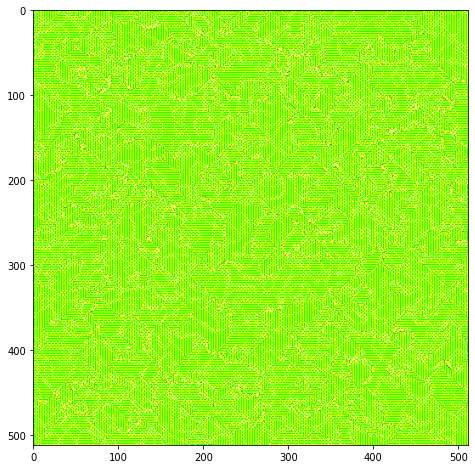

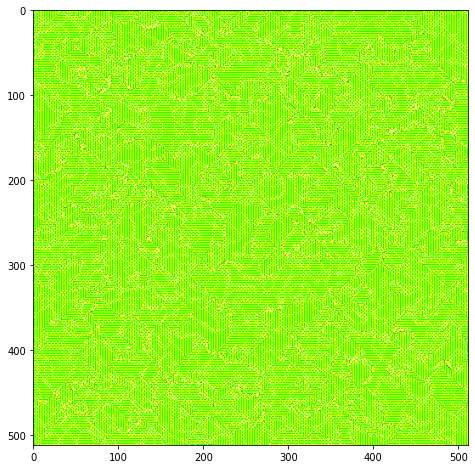

In [9]:
CA_run = population[0]
CA_run.initGrid(BS=1)
RES = 512

# CENTER SEED
# x = torch.cuda.FloatTensor(np.zeros((HIDDEN, RES, RES))).unsqueeze(0)
# x[:, 3:, RES//2, RES//2] = 1
# x[:, 3:, RES//3 : 2*RES//3, RES//3 : 2*RES//3] = 1
x = torch.cuda.FloatTensor(np.random.random((HIDDEN, RES, RES)) > 0.9999).unsqueeze(0)
CA_run.psi = x

imgs = []

timeSteps = 1000

with torch.no_grad():
    for i in range(timeSteps):
        nx = CA_run.psi.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
        imgs.append(nx)

        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

        CA_run.forward()
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

# Train

In [ ]:
population = [CA().cuda() for i in range(100)]
timestr = time.strftime("%Y%m%d-%H%M%S")

'''
for i in range(1,len(population)):
    population[i].rule.filter1.data = population[0].rule.filter1.data.detach()
    population[i].rule.bias1.data = population[0].rule.bias1.data.detach()
    population[i].rule.filter2.weight.data = population[0].rule.filter2.weight.data.detach()
    population[i].rule.filter3.weight.data = population[0].rule.filter3.weight.data.detach()
    population[i].rule.filter2.bias.data = population[0].rule.filter2.bias.data.detach()
    population[i].rule.filter3.bias.data = population[0].rule.filter3.bias.data.detach()
'''

embed = Embedder().cuda()

emb_err = []
ca_err = []
hard_frac = []

e_optim = torch.optim.Adam(embed.parameters(), lr=1e-4)
tloss = nn.TripletMarginLoss()

CBS = 10 # should be even number (batchsize * 2)
# EBS = 15
# ESTEPS = 25
EBS = 5
ESTEPS = 50

writer = 

for epoch in range(1000):
    print(f'Epoch: {epoch}')
    e_loss = []
    c_loss = []
    h_loss = []

    zs = []
    xs = []
    with torch.no_grad():
        print('Generating embeddings for CAs...')
        for ca in population:
            lzs = []
            ca.initGrid(CBS)
            for j in range(25):
                ca.forward()
                
            x = []
            for j in range(3):
                x.append(ca.psi[:,0:1,:,:])
                ca.forward()
            x = torch.cat(x,1)
            
            lzs.append(embed.forward(x).cpu().detach().numpy())
            # lxs.append(ca.psi.cpu().detach().numpy())
            zs.append(np.concatenate(lzs, axis=0)[np.newaxis])
            ca.cleanup()
        zs = np.concatenate(zs, axis=0)

    # Train embedder
    print('Training embedder')
    for i in range(ESTEPS):
        x1 = []
        x2 = []
        x3 = []

        for j in range(EBS):
            a, b, hard = findHardNegative(zs)

            CA1 = population[a]
            CA2 = population[b]

            with torch.no_grad():
                CA1.initGrid(2)
                CA2.initGrid(1)

                K1 = 25
                K2 = 25

                for k in range(K1):
                    CA1.forward()
                    
                c1 = []
                for k in range(3):
                    c1.append(CA1.psi[:,0:1,:,:])
                    CA1.forward()
                c1 = torch.cat(c1,1)
                
                for k in range(K2):
                    CA2.forward()

                c2 = []
                for k in range(3):
                    c2.append(CA2.psi[:,0:1,:,:])
                    CA2.forward()
                c2 = torch.cat(c2,1)
                
                # is there a reason we're throwing these into CPU and then throwing them back on GPU later? 
                im1 = c1[0].cpu().detach().numpy()
                im2 = c1[1].cpu().detach().numpy()
                im3 = c2[0].cpu().detach().numpy()

                CA1.cleanup()
                CA2.cleanup()

            x1.append(im1)
            x2.append(im2)
            x3.append(im3)
            h_loss.append(hard)

        x1 = torch.cuda.FloatTensor(np.array(x1))
        x2 = torch.cuda.FloatTensor(np.array(x2))
        x3 = torch.cuda.FloatTensor(np.array(x3))

        e_optim.zero_grad()
        z1 = embed.forward(x1)
        z2 = embed.forward(x2)
        z3 = embed.forward(x3)

        loss = tloss(z1, z2, z3)
        loss.backward()
        e_optim.step()

        e_loss.append(loss.cpu().detach().item())

    emb_err.append(np.mean(e_loss))
    hard_frac.append(np.mean(h_loss))
    print(f'emb_err: {emb_err[-1]}, hard_frac: {hard_frac[-1]}')

    # Train CAs
    print('Training CAs')
    for ii in range(len(population) // 2):
        i = np.random.randint(len(population))
        CA1 = population[i]
        z1 = zs[i, 0]
        z2 = zs[i, 1]

        d12 = np.sqrt(np.sum((z1 - z2) ** 2, axis=0))
        step = 0
        while step < 1000:
            j = np.random.randint(len(population) - 1)
            if j >= i:
                j += 1

            z3 = zs[j, 0]

            d13 = np.sqrt(np.sum((z1 - z3) ** 2, axis=0))
            if d12 - d13 + 1 > 1:
                break

            step += 1

        CA2 = population[j]

        CA1.optim.zero_grad()
        CA2.optim.zero_grad()

        CA1.initGrid(CBS)
        CA2.initGrid(CBS//2)

        S1 = 25
        S2 = 25

        for j in range(S1):
            CA1.forward()
            
        c1 = []
        for k in range(3):
            c1.append(CA1.psi[:,0:1,:,:])
            CA1.forward()
        c1 = torch.cat(c1,1)

        for j in range(S2):
            CA2.forward()
            
        c2 = []
        for k in range(3):
            c2.append(CA2.psi[:,0:1,:,:])
            CA2.forward()
        c2 = torch.cat(c2,1)

        im = CA1.psi.detach().cpu().numpy()[0, 0, :, :] * 0.5 + 0.5
        im = (255 * np.clip(im, 0, 1)).astype(np.uint8)
        im = Image.fromarray(im)
#         im = CA1.psi.detach().cpu().numpy()[0, 0:1, :, :].transpose(1, 2, 0) * 0.5 + 0.5
#         im = (im * 255).astype('uint8')
#         im = Image.fromarray(im, 'RGB')
        
#         fpath = path.join('frames', timestr, 'epoch_' + str(epoch).zfill(3))
        fpath = path.join('frames', timestr, 'CA', 'CA_' + str(i).zfill(5)) # images saved according to CA
        fpath_epoch = path.join('frames', timestr, 'all', 'epoch_' + str(epoch).zfill(3)) # images saved according to epoch
        if not path.exists(fpath):
            makedirs(fpath)
        if not path.exists(fpath_epoch):
            makedirs(fpath_epoch)
        im.save(path.join(fpath, str(i).zfill(5) + '_epoch_' + str(epoch).zfill(3) + '.png'))
        im.save(path.join(fpath_epoch, 'CA_' + str(i).zfill(5) + '.png'))
        
        z1 = embed.forward(c1)
        z3 = embed.forward(c2)

        z2 = z1[CBS//2:]
        z1 = z1[:CBS//2]

        loss = tloss(z1,z2,z3)
        loss.backward()
        CA1.optim.step()
        CA2.optim.step()

        c_loss.append(loss.cpu().detach().item())

        CA1.cleanup()
        CA2.cleanup()

    ca_err.append(np.mean(c_loss))
    print(f'CA_loss: {ca_err[-1]}')

    np.savetxt("embed.txt", np.array(emb_err))
    np.savetxt("ca.txt", np.array(ca_err))
    np.savetxt("hard.txt", np.array(hard_frac))


In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(hard_frac, lw=2)
plt.xlabel('Epochs')
plt.ylabel('Steps to find hard negative')

In [ ]:
er = np.loadtxt("embed.txt")
cr = np.loadtxt("ca.txt")
h = np.loadtxt("hard.txt")

In [ ]:
plt.plot(h, '.')


In [ ]:
plt.plot(er, '.')
plt.plot(cr, '.')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def load_model(name):
    folder = 'models/' + name + '/'
    er = np.loadtxt(folder + 'embed.txt')
    cr = np.loadtxt(folder + "ca.txt")
    h = np.loadtxt(folder + "hard.txt")
    
    return er, cr, h

def make_figs(er, cr, h):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(h, '.')
    ax[0].set_title('Avg. Hard-negative mining steps')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Steps')

    ax[1].plot(er, '.', label='Embedder')
    ax[1].plot(cr, '.', label='CA')
    ax[1].set_title('CA and Discriminator triplet loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Tloss')
    plt.legend()

In [ ]:
name = 'model_p500_20200825-152225'
make_figs(*load_model(name))

name = 'model_p100_20200824-192902'
make_figs(*load_model(name))

name = 'model_p100_20200826-200433'
make_figs(*load_model(name))


In [ ]:
plt.plot(er, '.', label='Embedder')
plt.plot(cr, '.', label='CA')
plt.title('CA and Discriminator triplet loss')
plt.xlabel('Epoch')
plt.ylabel('Tloss')
plt.legend()

In [69]:
# Random Debug

rule.filter1 tensor([[[[ 2.2617e-01,  5.9438e-01, -3.1430e-01, -2.7419e-01,  8.4107e-02],
          [-1.8079e-01, -5.3352e-01, -5.1989e-01, -4.1335e-01, -5.0977e-02],
          [ 7.2792e-01,  1.6546e-01,  1.5876e-01,  4.6031e-02,  3.0694e-01],
          [ 2.1683e-01,  1.9443e-01, -6.8979e-01, -7.2702e-02,  2.8753e-01],
          [ 4.7925e-02,  1.6745e-01,  2.1921e-02, -2.7158e-01,  4.9906e-02]]],


        [[[-7.0463e-01, -5.6205e-01, -3.2676e-01,  1.6517e-01, -1.9197e-01],
          [-2.0698e-01,  2.6919e-01,  1.1224e+00,  3.8443e-01,  2.6465e-02],
          [ 6.0755e-01, -1.0090e-01,  5.7200e-01, -1.3588e+00,  5.0914e-03],
          [ 4.1768e-01,  4.7789e-01,  2.0834e-01,  1.7724e-01,  6.8256e-01],
          [ 7.6752e-01, -6.5811e-02,  7.3083e-01,  6.2886e-01,  2.7979e-01]]],


        [[[ 8.2700e-02, -4.5779e-01, -7.4596e-01,  6.7000e-01,  3.6815e-01],
          [ 4.8589e-01,  6.3929e-01,  7.0321e-01, -1.6638e-01, -2.3081e-01],
          [-4.3866e-02,  5.4595e-01, -4.8972e-01,  3.72

# Test

In [12]:
population = [CA().cuda() for i in range(1)]
for ca in population:
    ca.initGrid(BS=1)
# embed = Embedder().cuda()

950


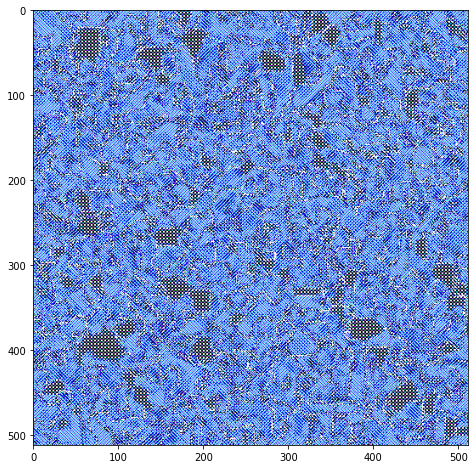

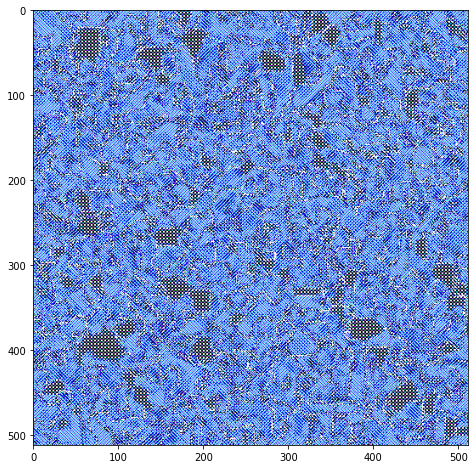

In [15]:
CA_run = population[0]
CA_run.initGrid(BS=1)
RES = 512

# CENTER SEED
# x = torch.cuda.FloatTensor(np.zeros((HIDDEN, RES, RES))).unsqueeze(0)
# x[:, 3:, RES//2, RES//2] = 1
# x[:, 3:, RES//3 : 2*RES//3, RES//3 : 2*RES//3] = 1
x = torch.cuda.FloatTensor(np.random.random((HIDDEN, RES, RES)) > 0.9999).unsqueeze(0)
CA_run.psi = x

imgs = []

timeSteps = 1000

with torch.no_grad():
    for i in range(timeSteps):
        nx = CA_run.psi.cpu().numpy()[0, 0:4, :, :].transpose(1, 2, 0)
        nx = rgba2rgb(nx)
        imgs.append(nx)

        if i%50 == 0:
            plt.clf()
            plt.imshow(nx)
            plt.gcf().set_size_inches((8,8))
            clear_output(wait=True)
            print(f'{i}')
            display(plt.gcf())
            time.sleep(0.01)

        CA_run.forward()
    

fname = time.strftime("%Y%m%d-%H%M%S")
out = cv2.VideoWriter(f'CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RES, RES), 3)

for img in imgs:
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    out.write(img)
out.release()

# Train

In [ ]:
population = [CA().cuda() for i in range(100)]
timestr = time.strftime("%Y%m%d-%H%M%S")

'''
for i in range(1,len(population)):
    population[i].rule.filter1.data = population[0].rule.filter1.data.detach()
    population[i].rule.bias1.data = population[0].rule.bias1.data.detach()
    population[i].rule.filter2.weight.data = population[0].rule.filter2.weight.data.detach()
    population[i].rule.filter3.weight.data = population[0].rule.filter3.weight.data.detach()
    population[i].rule.filter2.bias.data = population[0].rule.filter2.bias.data.detach()
    population[i].rule.filter3.bias.data = population[0].rule.filter3.bias.data.detach()
'''

embed = Embedder().cuda()

emb_err = []
ca_err = []
hard_frac = []

e_optim = torch.optim.Adam(embed.parameters(), lr=1e-4)
tloss = nn.TripletMarginLoss()

CBS = 10 # should be even number (batchsize * 2)
# EBS = 15
# ESTEPS = 25
EBS = 5
ESTEPS = 50

writer = 

for epoch in range(1000):
    print(f'Epoch: {epoch}')
    e_loss = []
    c_loss = []
    h_loss = []

    zs = []
    xs = []
    with torch.no_grad():
        print('Generating embeddings for CAs...')
        for ca in population:
            lzs = []
            ca.initGrid(CBS)
            for j in range(25):
                ca.forward()
                
            x = []
            for j in range(3):
                x.append(ca.psi[:,0:1,:,:])
                ca.forward()
            x = torch.cat(x,1)
            
            lzs.append(embed.forward(x).cpu().detach().numpy())
            # lxs.append(ca.psi.cpu().detach().numpy())
            zs.append(np.concatenate(lzs, axis=0)[np.newaxis])
            ca.cleanup()
        zs = np.concatenate(zs, axis=0)

    # Train embedder
    print('Training embedder')
    for i in range(ESTEPS):
        x1 = []
        x2 = []
        x3 = []

        for j in range(EBS):
            a, b, hard = findHardNegative(zs)

            CA1 = population[a]
            CA2 = population[b]

            with torch.no_grad():
                CA1.initGrid(2)
                CA2.initGrid(1)

                K1 = 25
                K2 = 25

                for k in range(K1):
                    CA1.forward()
                    
                c1 = []
                for k in range(3):
                    c1.append(CA1.psi[:,0:1,:,:])
                    CA1.forward()
                c1 = torch.cat(c1,1)
                
                for k in range(K2):
                    CA2.forward()

                c2 = []
                for k in range(3):
                    c2.append(CA2.psi[:,0:1,:,:])
                    CA2.forward()
                c2 = torch.cat(c2,1)
                
                # is there a reason we're throwing these into CPU and then throwing them back on GPU later? 
                im1 = c1[0].cpu().detach().numpy()
                im2 = c1[1].cpu().detach().numpy()
                im3 = c2[0].cpu().detach().numpy()

                CA1.cleanup()
                CA2.cleanup()

            x1.append(im1)
            x2.append(im2)
            x3.append(im3)
            h_loss.append(hard)

        x1 = torch.cuda.FloatTensor(np.array(x1))
        x2 = torch.cuda.FloatTensor(np.array(x2))
        x3 = torch.cuda.FloatTensor(np.array(x3))

        e_optim.zero_grad()
        z1 = embed.forward(x1)
        z2 = embed.forward(x2)
        z3 = embed.forward(x3)

        loss = tloss(z1, z2, z3)
        loss.backward()
        e_optim.step()

        e_loss.append(loss.cpu().detach().item())

    emb_err.append(np.mean(e_loss))
    hard_frac.append(np.mean(h_loss))
    print(f'emb_err: {emb_err[-1]}, hard_frac: {hard_frac[-1]}')

    # Train CAs
    print('Training CAs')
    for ii in range(len(population) // 2):
        i = np.random.randint(len(population))
        CA1 = population[i]
        z1 = zs[i, 0]
        z2 = zs[i, 1]

        d12 = np.sqrt(np.sum((z1 - z2) ** 2, axis=0))
        step = 0
        while step < 1000:
            j = np.random.randint(len(population) - 1)
            if j >= i:
                j += 1

            z3 = zs[j, 0]

            d13 = np.sqrt(np.sum((z1 - z3) ** 2, axis=0))
            if d12 - d13 + 1 > 1:
                break

            step += 1

        CA2 = population[j]

        CA1.optim.zero_grad()
        CA2.optim.zero_grad()

        CA1.initGrid(CBS)
        CA2.initGrid(CBS//2)

        S1 = 25
        S2 = 25

        for j in range(S1):
            CA1.forward()
            
        c1 = []
        for k in range(3):
            c1.append(CA1.psi[:,0:1,:,:])
            CA1.forward()
        c1 = torch.cat(c1,1)

        for j in range(S2):
            CA2.forward()
            
        c2 = []
        for k in range(3):
            c2.append(CA2.psi[:,0:1,:,:])
            CA2.forward()
        c2 = torch.cat(c2,1)

        im = CA1.psi.detach().cpu().numpy()[0, 0, :, :] * 0.5 + 0.5
        im = (255 * np.clip(im, 0, 1)).astype(np.uint8)
        im = Image.fromarray(im)
#         im = CA1.psi.detach().cpu().numpy()[0, 0:1, :, :].transpose(1, 2, 0) * 0.5 + 0.5
#         im = (im * 255).astype('uint8')
#         im = Image.fromarray(im, 'RGB')
        
#         fpath = path.join('frames', timestr, 'epoch_' + str(epoch).zfill(3))
        fpath = path.join('frames', timestr, 'CA', 'CA_' + str(i).zfill(5)) # images saved according to CA
        fpath_epoch = path.join('frames', timestr, 'all', 'epoch_' + str(epoch).zfill(3)) # images saved according to epoch
        if not path.exists(fpath):
            makedirs(fpath)
        if not path.exists(fpath_epoch):
            makedirs(fpath_epoch)
        im.save(path.join(fpath, str(i).zfill(5) + '_epoch_' + str(epoch).zfill(3) + '.png'))
        im.save(path.join(fpath_epoch, 'CA_' + str(i).zfill(5) + '.png'))
        
        z1 = embed.forward(c1)
        z3 = embed.forward(c2)

        z2 = z1[CBS//2:]
        z1 = z1[:CBS//2]

        loss = tloss(z1,z2,z3)
        loss.backward()
        CA1.optim.step()
        CA2.optim.step()

        c_loss.append(loss.cpu().detach().item())

        CA1.cleanup()
        CA2.cleanup()

    ca_err.append(np.mean(c_loss))
    print(f'CA_loss: {ca_err[-1]}')

    np.savetxt("embed.txt", np.array(emb_err))
    np.savetxt("ca.txt", np.array(ca_err))
    np.savetxt("hard.txt", np.array(hard_frac))


Epoch: 0
Generating embeddings for CAs...
Training embedder
emb_err: 0.8143644607067109, hard_frac: 7.316
Training CAs
CA_loss: 0.2308427785197273
Epoch: 1
Generating embeddings for CAs...
Training embedder
emb_err: 0.893332542181015, hard_frac: 23.404
Training CAs
CA_loss: 0.4475077386303747
Epoch: 2
Generating embeddings for CAs...
Training embedder
emb_err: 0.8661015725135803, hard_frac: 15.38
Training CAs
CA_loss: 0.31911137349437924
Epoch: 3
Generating embeddings for CAs...
Training embedder
emb_err: 0.8800523257255555, hard_frac: 21.104
Training CAs
CA_loss: 0.5218810345977545
Epoch: 4
Generating embeddings for CAs...
Training embedder
emb_err: 0.7328034979104996, hard_frac: 15.54
Training CAs
CA_loss: 0.3375085748136917
Epoch: 5
Generating embeddings for CAs...
Training embedder
emb_err: 0.8552757948637009, hard_frac: 17.148
Training CAs
CA_loss: 0.33706618040800096
Epoch: 6
Generating embeddings for CAs...
Training embedder
emb_err: 0.8120147758722305, hard_frac: 23.392
Trainin

Text(0, 0.5, 'Steps to find hard negative')

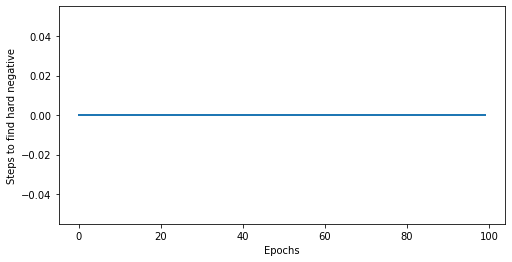

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(hard_frac, lw=2)
plt.xlabel('Epochs')
plt.ylabel('Steps to find hard negative')

In [18]:
er = np.loadtxt("embed.txt")
cr = np.loadtxt("ca.txt")
h = np.loadtxt("hard.txt")

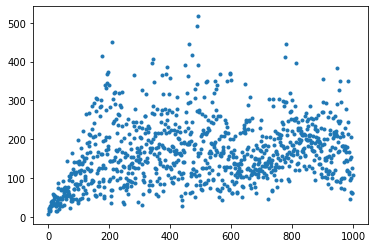

In [18]:
plt.plot(h, '.')


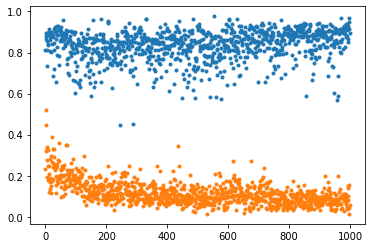

In [21]:
plt.plot(er, '.')
plt.plot(cr, '.')

In [84]:
import numpy as np
import matplotlib.pyplot as plt

def load_model(name):
    folder = 'models/' + name + '/'
    er = np.loadtxt(folder + 'embed.txt')
    cr = np.loadtxt(folder + "ca.txt")
    h = np.loadtxt(folder + "hard.txt")
    
    return er, cr, h

def make_figs(er, cr, h):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(h, '.')
    ax[0].set_title('Avg. Hard-negative mining steps')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Steps')

    ax[1].plot(er, '.', label='Embedder')
    ax[1].plot(cr, '.', label='CA')
    ax[1].set_title('CA and Discriminator triplet loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Tloss')
    plt.legend()

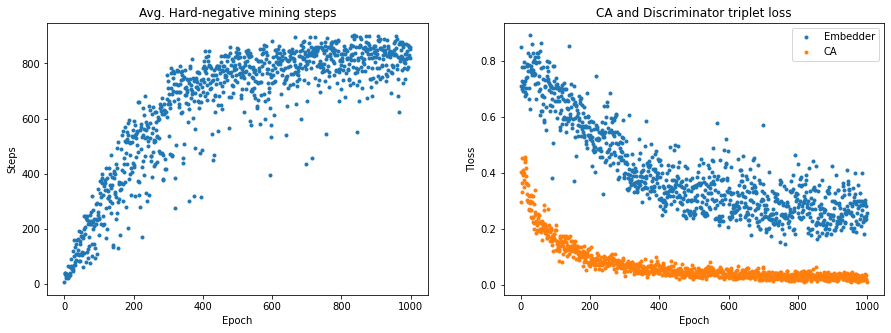

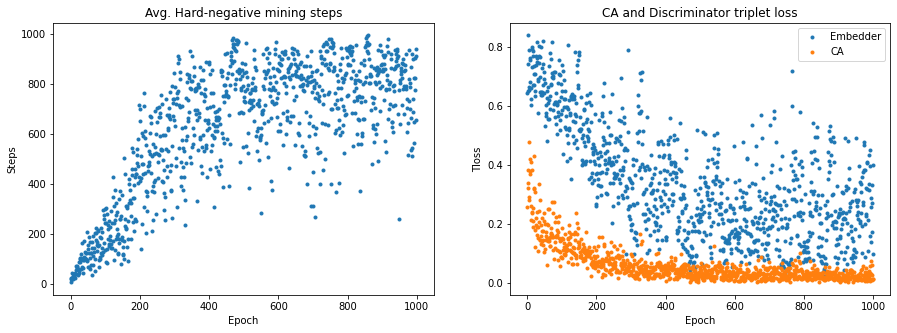

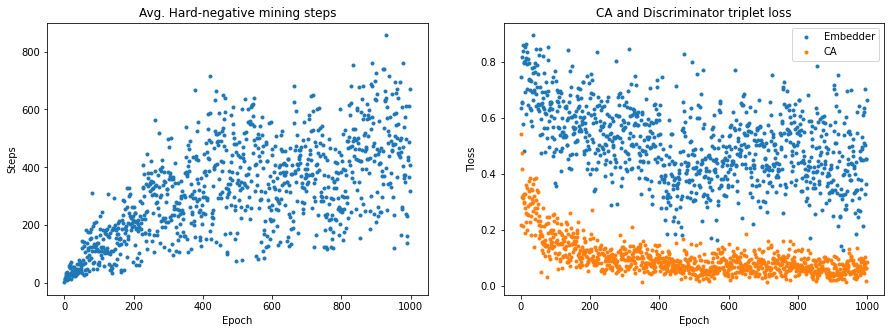

In [88]:
name = 'model_p500_20200825-152225'
make_figs(*load_model(name))

name = 'model_p100_20200824-192902'
make_figs(*load_model(name))

name = 'model_p100_20200826-200433'
make_figs(*load_model(name))


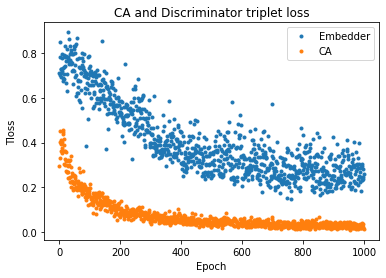

In [54]:
plt.plot(er, '.', label='Embedder')
plt.plot(cr, '.', label='CA')
plt.title('CA and Discriminator triplet loss')
plt.xlabel('Epoch')
plt.ylabel('Tloss')
plt.legend()

# Random Debug

In [ ]:
im1 = CA1.psi.cpu().detach().numpy()[0, 0:3, :, :].transpose(1, 2, 0)
im2 = CA1.psi.cpu().detach().numpy()[1, 0:3, :, :].transpose(1, 2, 0)
plt.imshow(np.abs(im2-im1)/2)

In [4]:
x.shape

torch.Size([10, 3, 128, 128])

In [120]:
zs.shape